In [ ]:
import pandas as pd

# 데이터 경로
data_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle/Plant Pathology 2020/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [ ]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [ ]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [ ]:
# 데이터를 타깃값별로 추출
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

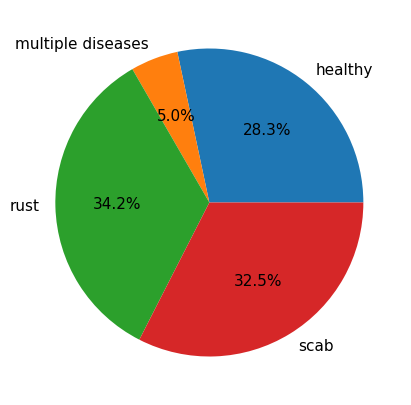

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=11)
plt.figure(figsize=(5,5))

label=['healthy', 'multiple diseases', 'rust', 'scab'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)], labels=label, autopct='%.1f%%');

In [ ]:
import matplotlib.gridspec as gridspec
import cv2 # OpenCV 라이브러리

def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    plt.figure(figsize=(15, 8))
    grid = gridspec.GridSpec(rows, cols)
    
    for idx, img_id in enumerate(img_ids):
        img_path = f'{data_path}/images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력

In [ ]:
# 각 타깃값별 image_id(마지막 6개)
num_of_imgs = 6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

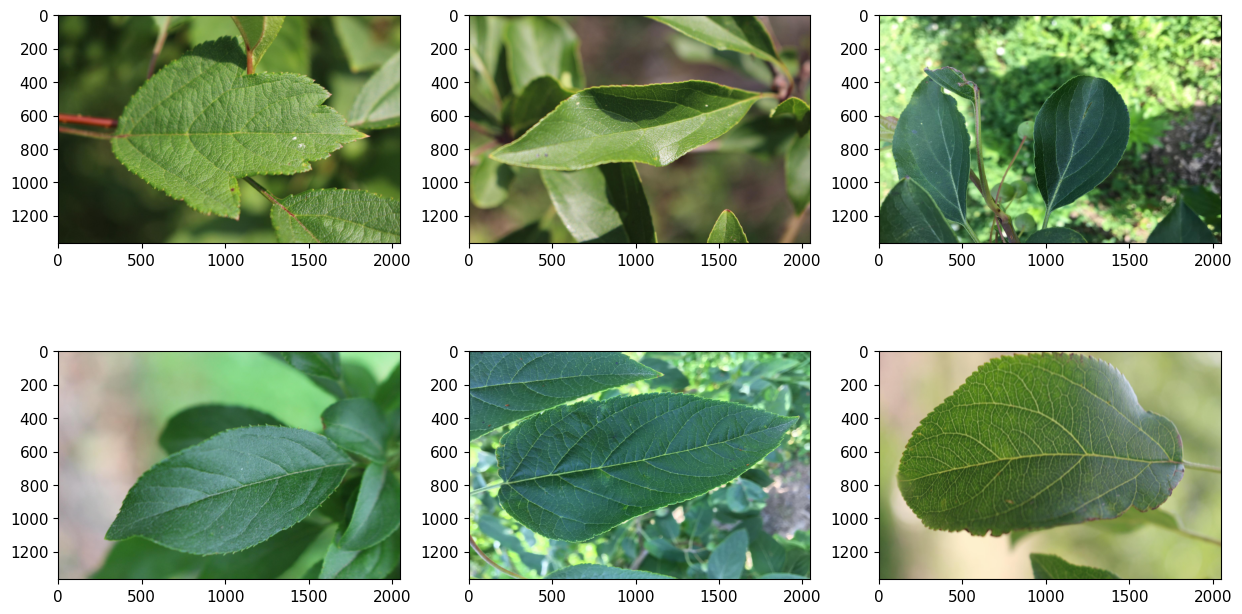

In [ ]:
show_image(last_healthy_img_ids) # 건강한 잎사귀 출력

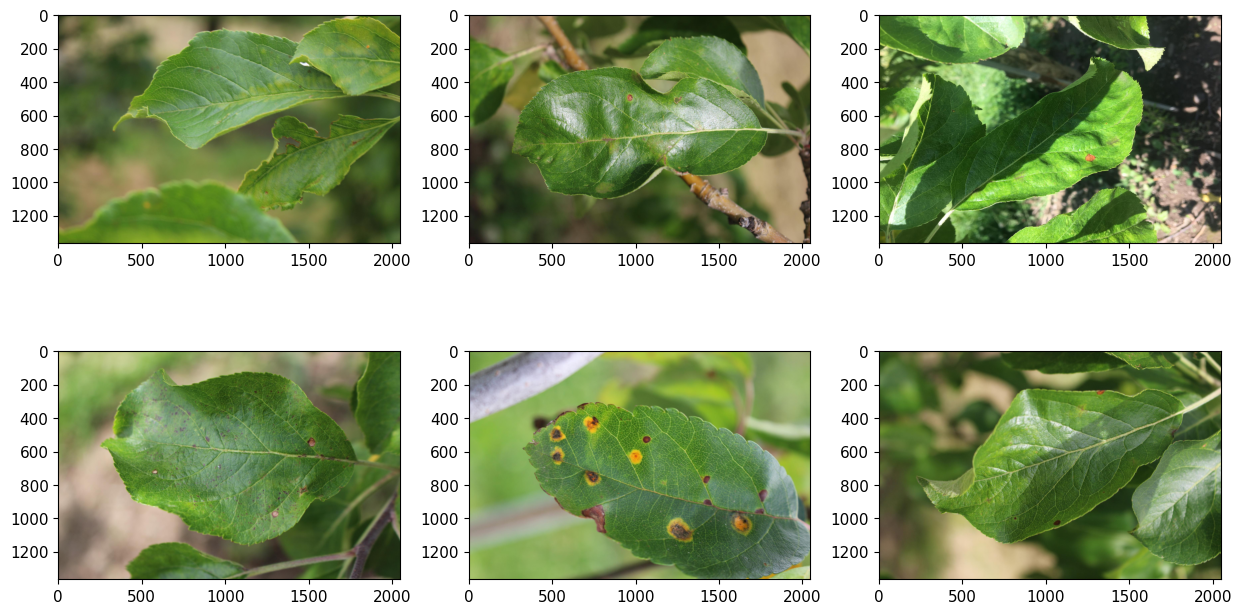

In [ ]:
show_image(last_multiple_diseases_img_ids) # 여러 질병에 걸린 잎사귀 출력

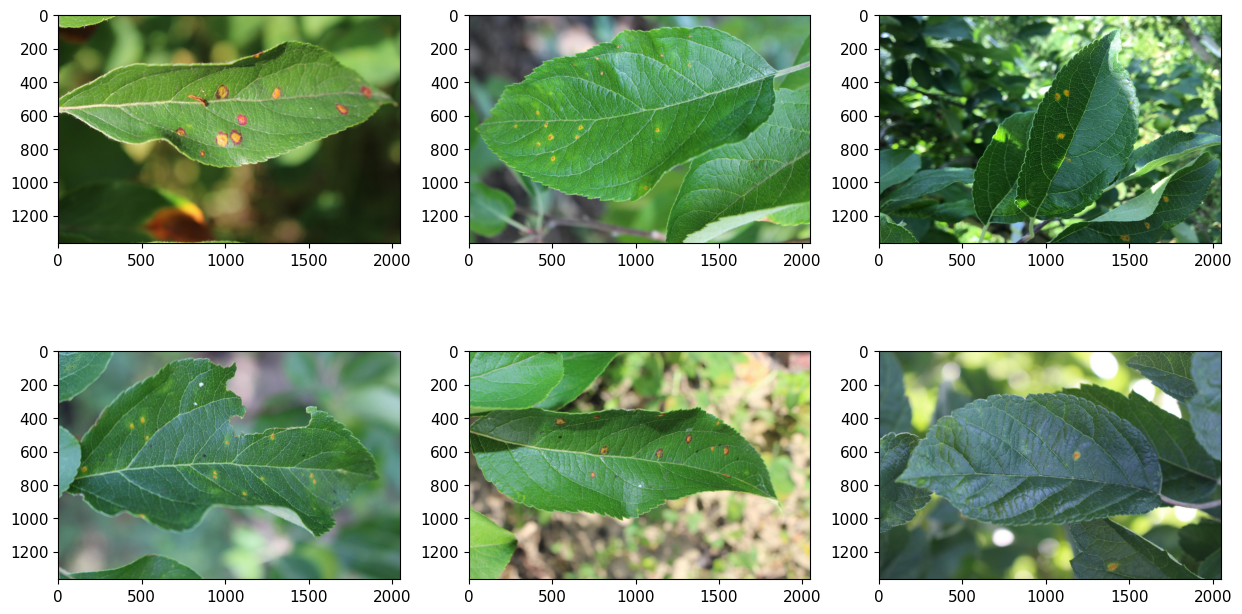

In [ ]:
show_image(last_rust_img_ids) # 녹병에 걸린 잎사귀 출력

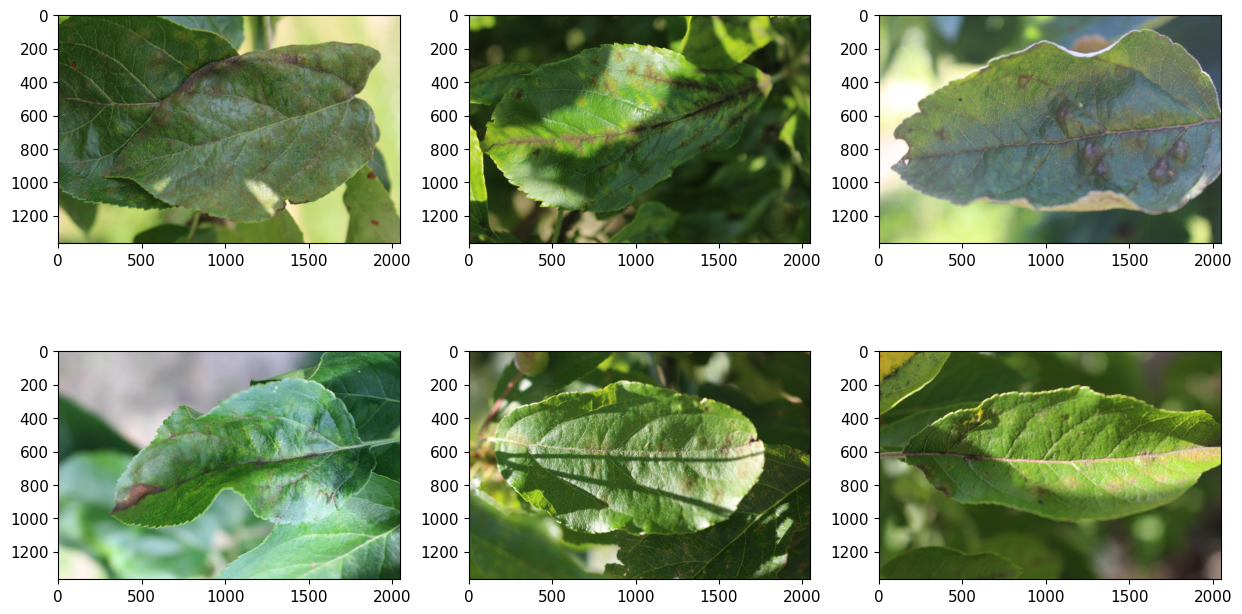

In [ ]:
show_image(last_scab_img_ids) # 붉은곰팡이병에 걸린 잎사귀

## **베이스라인 모델**

In [ ]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import pandas as pd

# 데이터 경로
data_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle/Plant Pathology 2020/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [ ]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(train, test_size=0.1, stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']], random_state=50)

In [ ]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일 경로
        image = cv2.imread(img_path)              # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        # 이미지 변환 
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환 
        if self.is_test:
            return image # 테스트용일 때
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스 
            label = np.argmax(self.df.iloc[idx, 1:5]) 
            return image, label # 훈련/검증용일 때

In [ ]:
# 이미지 변환을 위한 모듈
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절 
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환 
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환
])

# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

In [ ]:
img_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/Plant Pathology 2020/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [ ]:
!pip install efficientnet-pytorch==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=2fcdab3fbeda6f3336c0e5961a8185edf46c11362a6e0577e5cd40e63523b611
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) 

model = model.to(device) # 장비 할당

Loaded pretrained weights for efficientnet-b7


In [ ]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu()].numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')  

  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [1/5] - 훈련 데이터 손실값 : 0.6971
에폭 [1/5] - 검증 데이터 손실값 : 0.2675 / 검증 데이터 ROC AUC : 0.9592


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [2/5] - 훈련 데이터 손실값 : 0.3434
에폭 [2/5] - 검증 데이터 손실값 : 0.1957 / 검증 데이터 ROC AUC : 0.9672


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [3/5] - 훈련 데이터 손실값 : 0.2578
에폭 [3/5] - 검증 데이터 손실값 : 0.1900 / 검증 데이터 ROC AUC : 0.9575


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [4/5] - 훈련 데이터 손실값 : 0.1696
에폭 [4/5] - 검증 데이터 손실값 : 0.3024 / 검증 데이터 ROC AUC : 0.9737


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [5/5] - 훈련 데이터 손실값 : 0.1371
에폭 [5/5] - 검증 데이터 손실값 : 0.1717 / 검증 데이터 ROC AUC : 0.9807


In [ ]:
dataset_test = ImageDataset(test, img_dir=img_dir, transform=transform_test, is_test=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=2)

In [ ]:
model.eval() # 모델을 평가 상태로 설정

preds = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화
batch_size=4
with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        ouputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()

        if i == len(test_loader) - 1 and len(images) != batch_size:
            idx_size = len(images)
            preds[idx*batch_size: idx*batch_size+idx_size] += preds_part[:idx_size]
        else:
            preds[idx*batch_size:(idx+1)*batch_size] += preds_part

In [ ]:
submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds
submission.to_csv('submission.csv', index=False)

## **성능 개선**

In [ ]:
from transformers import get_cosine_schedule_with_warmup
epochs = 39 # 총 에폭

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(loader_train)*3, num_training_steps=len(loader_train)*epochs)

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ===============================================
    model.train()        # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item()
        loss.backward()  # 역전파 수행
        optimizer.step() # 가중치 갱신
        scheduler.step() # 스케줄러 학습률 갱신
    
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] =================================================
    model.eval()             # 모델을 평가 상태로 설정
    epoch_valid_loss = 0     # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []          # 예측 확률값 저장용 리스트 초기화
    true_onehot_list = []    # 실제 타깃값 저장용 리스트 초기화
    
    with torch.no_grad():    # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실젯값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu()].numpy()
            # 예측 확률값과 실젯갑 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
        # 검증 데이터 손실값 및 ROC AUC 점수 출력
        print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')

In [ ]:
# 테스트 데이터 원본용 데이터셋 및 데이터 로더
dataset_test = ImageDataset(test, img_dir = img_dir, transform = transform_test, is_test = True)
loader_test = DataLoader(dataset_test, batch_size = batch_size, shuffle=False, worker_init_fn = seed_worker, generator=g, num_workers=2)

# TTA용 데이터셋 및 데이터 로더
dataset_TTA = ImageDataset(test, img_dir=img_dir, transform=transform_train, is_test=True)
loader_TTA = DataLoader(dataset_TTA, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g, bum_workers=2)

In [ ]:
model.eval() # 모델을 평가 상태로 설정

preds_test = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

In [ ]:
num_TTA = 7 # TTA 횟수
preds_tta = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화 (TTA용)

# TTA를 적용해 예측
for i in range(num_TTA):
  with torch.no_grad():
    for i, images in enumerate(loader_TTA):
      images = images.to(device)
      outputs = model(images)
      # 타깃 예측 확률
      preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
      if i == len(test_loader) - 1 and len(images) != batch_size:
          idx_size = len(images)
          preds_tta[i*batch_size: i*batch_size+idx_size] += preds_part[:idx_size]
      else:
          preds_tta[i*batch_size:(i+1)*batch_size] += preds_part

preds_tta /= num_TTA

In [ ]:
submission_tta = submission.copy()
submission_tta[['healthy', 'multiple_diseases', 'rust', 'scab']] = preds_tta